         nat_sen  int_sen    exr  fdi_bs    fxr    inf    ipi    bot
nat_sen    1.000   -0.272 -0.002   0.041 -0.077 -0.060  0.329  0.251
int_sen   -0.272    1.000  0.066   0.054 -0.086 -0.017 -0.077  0.020
exr       -0.002    0.066  1.000   0.145 -0.665  0.461  0.124  0.295
fdi_bs     0.041    0.054  0.145   1.000 -0.236 -0.086 -0.090  0.332
fxr       -0.077   -0.086 -0.665  -0.236  1.000 -0.580  0.070 -0.415
inf       -0.060   -0.017  0.461  -0.086 -0.580  1.000 -0.083  0.128
ipi        0.329   -0.077  0.124  -0.090  0.070 -0.083  1.000  0.107
bot        0.251    0.020  0.295   0.332 -0.415  0.128  0.107  1.000


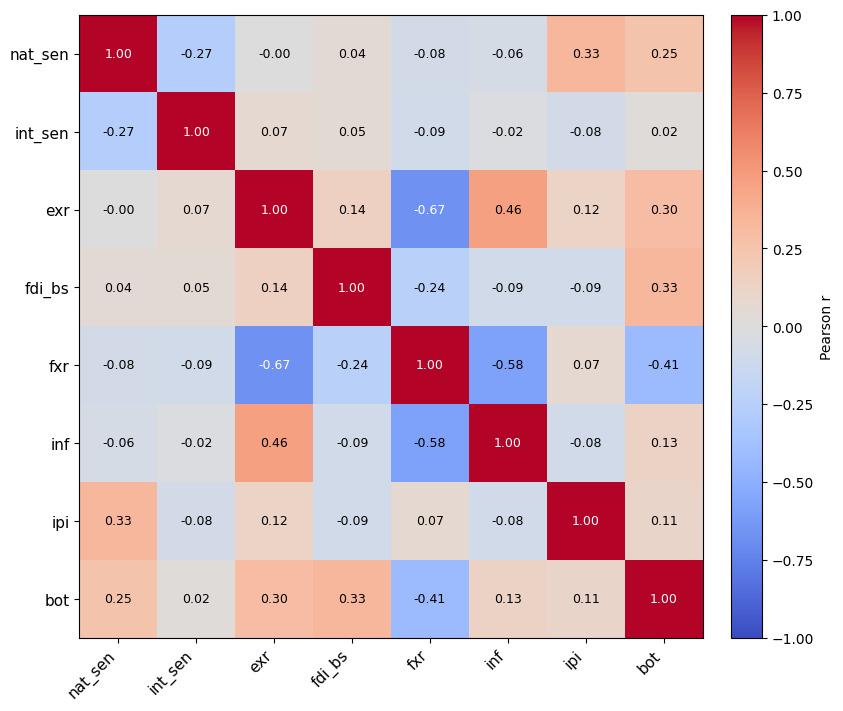

In [ ]:
#THE CODE BELOW GENERATES FIGURE 7, THE FINAL CORRELATION HEATMAP IN THE PAPER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

START = "2020-01-01"
END   = "2025-01-31"

# Paths
mr4_path      = "Sentiment_indicator/Mr4_national.csv"          # date, vn_sent, vn_score
finbert_path  = "Sentiment_indicator/Finbert_international.csv" # date, en_sent, en_score

macro_dir = "Macroeconomic_Indicator"
exr_path  = f"{macro_dir}/exchange_rate.csv"    # Date, USD/VND
fdi_path  = f"{macro_dir}/FDI-BS.csv"           # Date, sector, contrib_cap
fxr_path  = f"{macro_dir}/fx_reserves.csv"      # Date, USD (millions)
inf_path  = f"{macro_dir}/inflation_rate.csv"   # Date, Inf_YoY (%)
ipi_path  = f"{macro_dir}/IPI.csv"              # Date, IP YoY (%)
bot_path  = f"{macro_dir}/trade_balance.csv"    # Date, Trade_Balance (USD)

relevant_sectors = [
    "Professional, scientific and technical activities",
    "Information and communication",
    "Financial, banking and insurance activities",
]

def month_clip(s):
    s = pd.to_datetime(s, errors="coerce").dt.to_period("M").dt.to_timestamp()
    return s

def monthly_avg_weighted(df, date_col, sent_col, score_col, mapping):
    out = df.copy()
    out[date_col] = month_clip(out[date_col])
    out = out[(out[date_col] >= START) & (out[date_col] <= END)]
    out[sent_col] = out[sent_col].replace(mapping)
    weight = out[sent_col].map({"bullish": 1, "neutral": 0, "bearish": -1})
    out["weighted"] = weight * out[score_col]
    return out.groupby(date_col)["weighted"].mean()

def load_monthly_series(path, value_col, date_col="Date"):
    df = pd.read_csv(path, parse_dates=[date_col])
    df[date_col] = month_clip(df[date_col])
    df = df[(df[date_col] >= START) & (df[date_col] <= END)]
    return df.set_index(date_col)[value_col].astype(float)

#resetting the sentiment values of the models
#mr4 phobert is the nat_sen
mr4 = pd.read_csv(mr4_path)
nat_sen = monthly_avg_weighted(
    mr4, "date", "vn_sent", "vn_score",
    {"Tiêu cực": "bearish", "Tích cực": "bullish", "Trung tính": "neutral"}
).rename("nat_sen")

#finbert is the int_sen
fin = pd.read_csv(finbert_path)
int_sen = monthly_avg_weighted(
    fin, "date", "en_sent", "en_score",
    {"positive": "bullish", "neutral": "neutral", "negative": "bearish"}
).rename("int_sen")

#loading the macroeconomic indicators
exr = load_monthly_series(exr_path, "USD/VND").rename("exr")
fxr = load_monthly_series(fxr_path, "USD (millions)").rename("fxr")
inf = load_monthly_series(inf_path, "Inf_YoY (%)").rename("inf")
ipi = load_monthly_series(ipi_path, "IP YoY (%)").rename("ipi")
bot = load_monthly_series(bot_path, "Trade_Balance (USD)").rename("bot")

#processing FDI data
fdi = pd.read_csv(fdi_path, parse_dates=["Date"])
fdi["Date"] = month_clip(fdi["Date"])
fdi = fdi[(fdi["Date"] >= START) & (fdi["Date"] <= END)]
fdi = fdi[fdi["sector"].isin(relevant_sectors)].copy()
fdi["contrib_cap"] = pd.to_numeric(fdi["contrib_cap"], errors="coerce")
fdi_bs = fdi.groupby("Date")["contrib_cap"].sum().rename("fdi_bs")

#merging the variables into a single df
cols_order = ["nat_sen", "int_sen", "exr", "fdi_bs", "fxr", "inf", "ipi", "bot"]
all_series = [nat_sen, int_sen, exr, fdi_bs, fxr, inf, ipi, bot]
df_all = pd.concat(all_series, axis=1)[cols_order].dropna()

corr = df_all.corr().loc[cols_order, cols_order]
print(corr.round(3))

#plotting the correlation heatmap
fig, ax = plt.subplots(figsize=(8.5, 7), constrained_layout=True)
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")

ax.set_xticks(range(len(cols_order)))
ax.set_yticks(range(len(cols_order)))
ax.set_xticklabels(cols_order, rotation=45, ha="right", fontsize=11)
ax.set_yticklabels(cols_order, fontsize=11)

for i in range(len(cols_order)):
    for j in range(len(cols_order)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}",
                ha="center", va="center",
                color="black" if abs(corr.values[i, j]) < 0.6 else "white",
                fontsize=9)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Pearson r", rotation=90)

ax.set_title("",
             fontsize=14, fontweight="bold")
plt.show()
